In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Part 2
## Task 7

In [4]:
Q = np.array(
    [[-0.0085, 0.005, 0.0025, 0.0, 0.001],
     [0.0, -0.014, 0.005, 0.004, 0.005],
     [0.0, 0.0, -0.008, 0.003, 0.005],
     [0.0, 0.0, 0.0, -0.009, 0.009],
     [0.0, 0.0, 0.0, 0.0, 0.00]]
)

assert np.allclose(Q.sum(axis=1), 0), "Rows of Q should sum to zero"

P = np.zeros_like(Q)
for i in range(Q.shape[0]):
    if Q[i, i] != 0:
        P[i] = Q[i] / -Q[i, i]
        P[i, i] = 0  # Set diagonal to zero

assert np.allclose(P[:-1].sum(axis=1), 1), "Rows of P should sum to one"

# extract negative diagonal elements for easier indexing
Q_s = Q[:-1, :-1]
q = -1 / np.diag(Q_s)

In [5]:
P, q

(array([[0.        , 0.58823529, 0.29411765, 0.        , 0.11764706],
        [0.        , 0.        , 0.35714286, 0.28571429, 0.35714286],
        [0.        , 0.        , 0.        , 0.375     , 0.625     ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([117.64705882,  71.42857143, 125.        , 111.11111111]))

In [6]:
# Sampling time until next transition from state 2
print(np.random.exponential(q[2]))

# Sampling next state from state 2
print(np.random.choice([0, 1, 2, 3, 4], p=P[2]))

154.9109877036047
4


In [7]:
np.random.exponential(q[0])

172.19895219031778

In [8]:
def simulate_breast_cancer(womens: int):
    transitions = [[] for _ in range(womens)]  # Initialize transitions for each
    for woman in tqdm(range(womens), desc="Simulating breast cancer transitions"):
        state = 0
        t = 0.0
        while state < 4:
            time_to_next = np.random.exponential(q[state])
            next_state = np.random.choice(5, p=P[state])
            transitions[woman].append((t, state))

            t += time_to_next
            state = next_state
        transitions[woman].append((t, state))
    
    return transitions

np.random.seed(42)  # For reproducibility
results = simulate_breast_cancer(1000)

Simulating breast cancer transitions: 100%|██████████| 1000/1000 [00:00<00:00, 2619.29it/s]


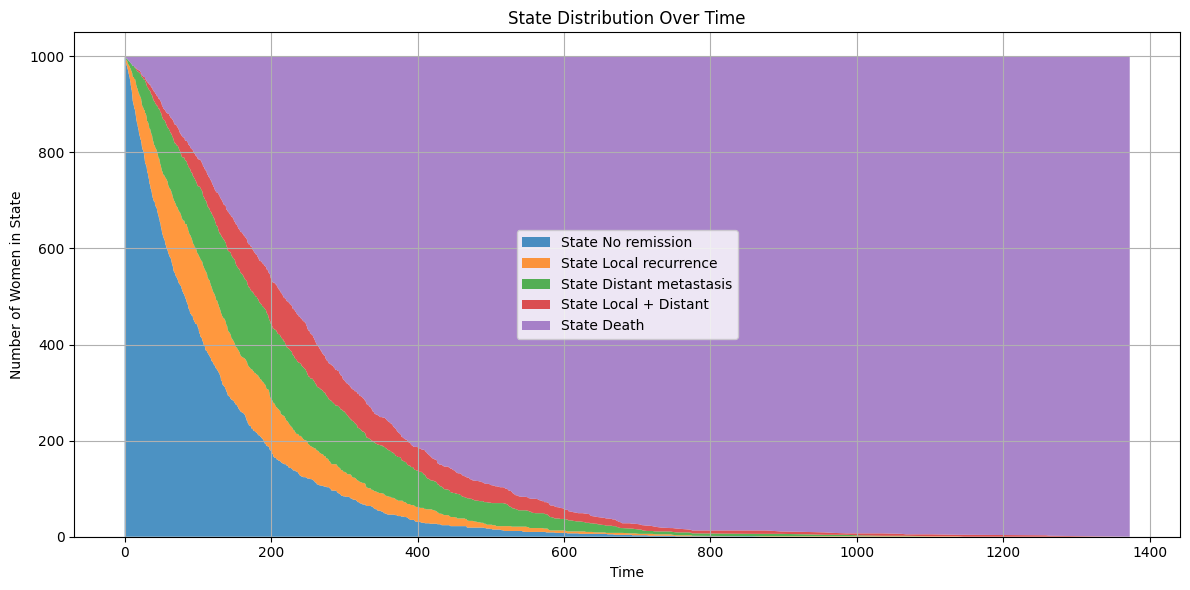

In [9]:
def construct_timeline(transitions):
    all_times = sorted({t for woman in transitions for (t, _) in woman})

    state_counts = np.zeros((len(all_times), 5))  # 5 states

    for woman in transitions:
        for i in range(len(woman) - 1):
            t_start, state = woman[i]
            t_end = woman[i+1][0]
            for j, t in enumerate(all_times):
                if t_start <= t < t_end:
                    state_counts[j, state] += 1
                    
        # For final absorbing state
        t_final, final_state = woman[-1]
        for j, t in enumerate(all_times):
            if t >= t_final:
                state_counts[j, final_state] += 1
    
    return all_times, state_counts

def plot_timeline(all_times, state_counts):
    labels = [
        "No remission",
        "Local recurrence",
        "Distant metastasis",
        "Local + Distant",
        "Death",
    ]
    plt.figure(figsize=(12, 6))
    plt.stackplot(all_times, state_counts.T, labels=[f"State {s}" for s in labels], alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Number of Women in State")
    plt.title("State Distribution Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

args = construct_timeline(results)
plot_timeline(*args)
    

-------

In [10]:
def get_lifetimes(transitions):
    return [women[-1][0] for women in transitions]
lifetimes = get_lifetimes(results)

In [11]:
def report_lifetime_statistics(lifetimes, confidence=0.95):
    n = len(lifetimes)
    mean = np.mean(lifetimes)
    std = np.std(lifetimes, ddof=1)

    z = norm.ppf(1 - (1 - confidence) / 2)
    se_mean = std / np.sqrt(n)
    se_std = std / np.sqrt(2 * (n - 1))  # Approximate SE of sample std

    ci_mean = (mean - z * se_mean, mean + z * se_mean)
    ci_std = (std - z * se_std, std + z * se_std)

    print(f"Mean lifetime: {mean:.2f} (95% CI: {ci_mean[0]:.2f} – {ci_mean[1]:.2f})")
    print(f"Standard deviation: {std:.2f} (95% CI: {ci_std[0]:.2f} – {ci_std[1]:.2f})")

report_lifetime_statistics(lifetimes, confidence=0.95)


Mean lifetime: 256.37 (95% CI: 244.32 – 268.42)
Standard deviation: 194.38 (95% CI: 185.86 – 202.90)


In [12]:

def simulate_breast_cancer(womens: int):
    states = np.zeros(womens, dtype=int)
    sojourns = np.random.exponential(q[0], womens)
    lifetimes = np.zeros(womens)
    alive = np.ones(womens, dtype=bool)

    state_history = []
    times = []
    time = 0.0

    with tqdm(total=womens, desc="Women dead") as pbar:
        while np.any(alive):
            # Skip to next event
            active_indices = np.where(alive)[0]
            event = active_indices[np.argmin(sojourns[alive])]

            elapsed = sojourns[event]
            sojourns[alive] -= elapsed
            lifetimes[event] += elapsed
            time += elapsed
            times.append(time)  # Store time of event

            new_state = np.random.choice(len(Q), p=P[states[event]])
            
            state_history.append(states.copy())
            # state_history.append((times[event], event, states[event], new_state))
            states[event] = new_state

            

            # Kill woman or update state and sojourn time
            if new_state == 4:
                alive[event] = False
                pbar.update(1)
            else:
                sojourns[event] = np.random.exponential(q[new_state])

    return {
        "lifetimes": lifetimes,
        "times": times,
        "state_history": np.array(state_history),
        "time": time,
        }


np.random.seed(23)  # For reproducibility
results = simulate_breast_cancer(1000)

Women dead:   0%|          | 0/1000 [00:00<?, ?it/s]

Women dead: 100%|██████████| 1000/1000 [00:00<00:00, 1931.28it/s]


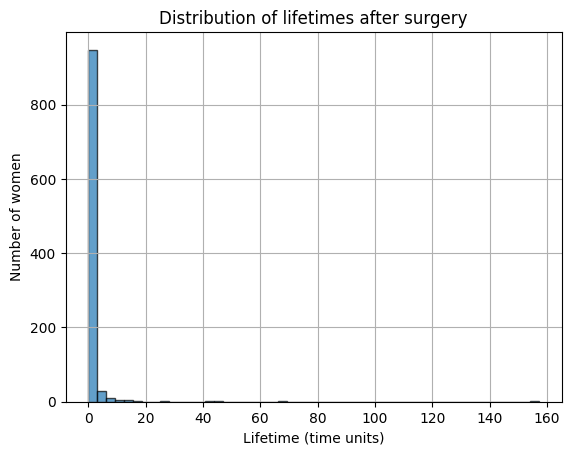

In [13]:
def plot_lifetimes(result_dict):
    lifetimes = result_dict["lifetimes"]
    plt.hist(lifetimes, bins=50, edgecolor='k', alpha=0.7)
    plt.xlabel("Lifetime (time units)")
    plt.ylabel("Number of women")
    # plt.xlim([0, 50])
    plt.title("Distribution of lifetimes after surgery")
    plt.grid(True)
    plt.show()
plot_lifetimes(results)

In [14]:
def report_lifetime_statistics(lifetimes, confidence=0.95):
    n = len(lifetimes)
    mean = np.mean(lifetimes)
    std = np.std(lifetimes, ddof=1)

    z = norm.ppf(1 - (1 - confidence) / 2)
    se_mean = std / np.sqrt(n)
    se_std = std / np.sqrt(2 * (n - 1))  # Approximate SE of sample std

    ci_mean = (mean - z * se_mean, mean + z * se_mean)
    ci_std = (std - z * se_std, std + z * se_std)

    print(f"Mean lifetime: {mean:.2f} (95% CI: {ci_mean[0]:.2f} – {ci_mean[1]:.2f})")
    print(f"Standard deviation: {std:.2f} (95% CI: {ci_std[0]:.2f} – {ci_std[1]:.2f})")

report_lifetime_statistics(results["lifetimes"], confidence=0.95)


Mean lifetime: 1.17 (95% CI: 0.80 – 1.54)
Standard deviation: 5.98 (95% CI: 5.72 – 6.24)


In [15]:
# In what proportion of women has the cancer reappeared distantly after 30.5 months?
def proportion_cancer_reappeared(lifetimes, threshold=30.5):
    return np.sum(lifetimes > threshold) / len(lifetimes)
print(f"Percentage of women with distant cancer reappearance after 30.5 months: {proportion_cancer_reappeared(results['lifetimes']):.2%}")
# Percentage of women with distant cancer reappearance after 30.5 months: 0.40%

Percentage of women with distant cancer reappearance after 30.5 months: 0.40%


In [16]:
i = np.searchsorted(results["times"], 30.5)
states_at_30_5 = results["state_history"][i]

# Count women in states 2 or above (meaning cancer has reappeared)
recurred_count = np.sum(states_at_30_5 >= 2)

proportion_recurred = recurred_count / len(states_at_30_5)
print(f"Proportion of women with cancer reappeared (state 2 or above) after 30.5 months: {proportion_recurred:.2%}")


Proportion of women with cancer reappeared (state 2 or above) after 30.5 months: 12.00%


## Task 8

In [17]:
from scipy.linalg import expm
from scipy.stats import chisquare

def theoritical_distribution(t):
    p_0 = np.array([1, 0, 0, 0])  # All start in state 0
    return p_0 @ expm(Q_s * t) * 1000

def empirical_distribution(t):
    i = np.searchsorted(results["times"], t)
    states = results["state_history"][i]

    counts = np.bincount(states)
    return counts

def chi_square_test(t):
    observed = empirical_distribution(t)[:-1]  # Exclude the absorbing state
    expected = theoritical_distribution(t)
    chi2_stat, p_value = chisquare(observed, expected)
    return chi2_stat, p_value

chi_square_test(30.5)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are:
0.00577596991141651

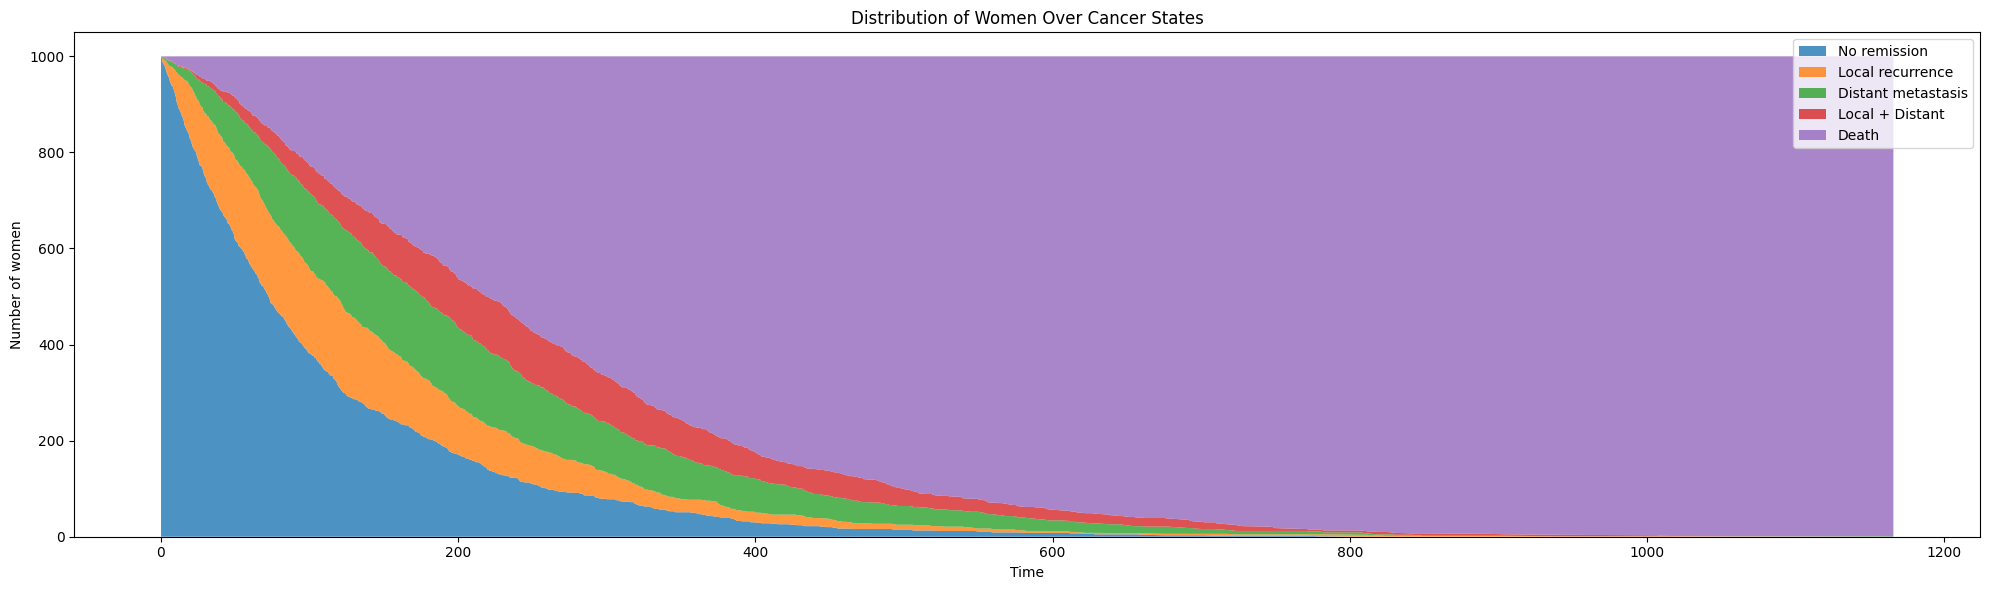

In [ ]:
x = results["times"]  # Times when transitions happened
state_history = results["state_history"]  # State of all women at each event

# Count how many women are in each state at each time point
counts = np.zeros(state_history.shape)

for i, state_vector in enumerate(state_history):
    unique, count = np.unique(state_vector, return_counts=True)
    counts[i, unique] = count

# Transpose for stackplot (shape: [num_states, timepoints])
y = counts.T

# Labels for states
labels = [
    "No remission",
    "Local recurrence",
    "Distant metastasis",
    "Local + Distant",
    "Death",
]

# Plot
fig, ax = plt.subplots(figsize=(20, 6))
ax.stackplot(x, y, labels=labels, alpha=0.8)
ax.set_xlabel("Time")
ax.set_ylabel("Number of women")
ax.set_title("Distribution of Women Over Cancer States")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


## Task 9

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st

In [67]:
# ---------- 1.  Generator matrices (raw) --------------------
Q_base_raw = np.array([
    [-0.0085, 0.005 , 0.0025, 0.0  , 0.001],
    [ 0.0   ,-0.014 , 0.005 , 0.004, 0.005],
    [ 0.0   , 0.0   ,-0.008 , 0.003, 0.005],
    [ 0.0   , 0.0   , 0.0   ,-0.009, 0.009],
    [ 0.0   , 0.0   , 0.0   , 0.0  , 0.0  ]
], dtype=float)

Q_prev_raw = np.array([
    [ 0.0   , 0.0025, 0.00125, 0.0  , 0.001],
    [ 0.0   , 0.0   , 0.0    , 0.002, 0.005],
    [ 0.0   , 0.0   , 0.0    , 0.003, 0.005],
    [ 0.0   , 0.0   , 0.0    , 0.0  , 0.009],
    [ 0.0   , 0.0   , 0.0    , 0.0  , 0.0  ]
], dtype=float)

def penis(Q):
    """Force each row of Q to sum to 0"""
    Q = Q.copy()
    for i in range(Q.shape[0]):
        off_sum = Q[i].sum() - Q[i, i]
        Q[i, i] = -off_sum
    return Q

Q_base = penis(Q_base_raw)
Q_prev = penis(Q_prev_raw)


In [68]:
# ---------- 2.  Build P and leave rates ---------------------
def build_P_and_rates(Q):
    """Return (P, λ) even if some rows are absorbing (λ = 0)."""
    n = Q.shape[0]
    P = np.zeros_like(Q)
    lambdas = np.zeros(n)
    for i in range(n):
        off = Q[i].copy()
        off[i] = 0
        rate = off.sum()
        lambdas[i] = rate
        if rate > 0:
            P[i] = off / rate
    return P, lambdas


In [69]:
# ---------- 3.  Simulator: one woman at a time ---------------
def simulate_lifetimes(Q, n, seed=None):
    rng = np.random.default_rng(seed)
    P, rate = build_P_and_rates(Q)
    death = Q.shape[0] - 1
    lifetimes = np.empty(n)

    for idx in tqdm(range(n), desc="Simulating", leave=False):
        t, state = 0.0, 0
        while state != death:
            t    += rng.exponential(scale=1.0 / rate[state])
            state = rng.choice(P.shape[0], p=P[state])
        lifetimes[idx] = t
    return lifetimes


In [70]:
N = 1_000
base = simulate_lifetimes(Q_base, N, seed=69)
prev = simulate_lifetimes(Q_prev, N, seed=420)

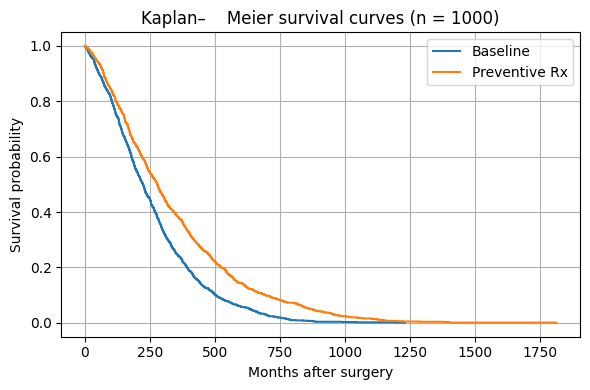

In [71]:
# ---------- 4.  Kaplan–Meier curve ---------------------------
def km_curve(times):
    times = np.sort(times)
    uniq  = np.unique(times)
    at_risk = len(times)
    surv = 1.0
    S = []
    for t in uniq:
        d = (times == t).sum()
        surv *= (1 - d / at_risk)
        S.append(surv)
        at_risk -= d
    return uniq, np.array(S)

t_base, S_base = km_curve(base)
t_prev, S_prev = km_curve(prev)

plt.figure(figsize=(6, 4))
plt.step(t_base, S_base, where="post", label="Baseline")
plt.step(t_prev, S_prev, where="post", label="Preventive Rx")
plt.xlabel("Months after surgery")
plt.ylabel("Survival probability")
plt.title(f"Kaplan–    Meier survival curves (n = {N})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

        

# Task 10 (Optional) 

Does the preventitive treatment have a significant effect on the survival function? Answer the question using a log-rank test.

In [74]:
# ---------- 5.  Two-sample log-rank test ---------------------
def logrank(times_a, times_b):
    ts = np.unique(np.concatenate([times_a, times_b]))
    Oa = Ea = Va = 0.0
    for t in ts:
        da = (times_a == t).sum()
        db = (times_b == t).sum()
        d  = da + db
        ra = (times_a >= t).sum()
        rb = (times_b >= t).sum()
        r  = ra + rb
        if r <= 1 or d == 0:
            continue
        ea = d * ra / r
        va = d * (ra / r) * (1 - ra / r) * (r - d) / (r - 1)
        Oa += da
        Ea += ea
        Va += va
    chi2 = (Oa - Ea)**2 / Va if Va > 0 else 0.0
    pval = 1 - st.chi2.cdf(chi2, 1)
    return chi2, pval
chi2, p = logrank(base, prev)
print(f"Log-rank test: χ² = {chi2:.3f},  p-value = {p:.4g}")

Log-rank test: χ² = 69.450,  p-value = 1.11e-16


The treatment does have a statistically significant effect on survival. A positive one, based on the kaplan meier plot.

# Task 11

For the report, consider the following questions: What assumptions have
been eliminated, by going from the discrete to the continuous time model?
What have been added? How could the model be extended, such that the
sojourn times are Erlang distributed?


Switching from a discrete-time to a continuous-time model removes the assumption that transitions can only occur at fixed time intervals, allowing events to happen at any point in time and making the model more realistic. However, it introduces the assumption that sojourn times are exponentially distributed, which implies memorylessness and may not always reflect real-world behavior. The model also assumes a Markov process, where future transitions depend only on the current state. To allow more realistic time-in-state distributions, such as Erlang distributions, each state can be split into multiple sequential substates with exponential transitions, effectively shaping the total sojourn time without losing the Markov property.